#  <ins>Verkehrsuntersuchung - Machine Learning</ins>

## Initialisierung

In [1]:
import gzip
import numpy as np
import pandas as pd
from sqlalchemy import create_engine#, text, MetaData, Table, Column, String
from geopy.geocoders import Nominatim
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import norm

In [2]:
sql_password = '' # Benutze hier dein MySQL- Passwort
engine = create_engine('mysql+mysqlconnector://root:' + sql_password + '@localhost:3306/verkehrsprojekt')
connection = engine.connect()

## Machine Learning

#### Dataframe erstellen

In [3]:
# pkw- Spalte

query = f"""
SELECT  
    timestamp, Durchschnitt
FROM 
    pkw_daten
"""
df = pd.read_sql(query,engine)
df = df.rename(columns = {'Durchschnitt':'Anzahl PKW'})
df  = df.set_index('timestamp')
pkw_spalte = df

In [4]:
# Fahrrad- Spalte

query = f"""
SELECT  
    timestamp, Durchschnitt
FROM 
    fahrraddaten
"""
df = pd.read_sql(query,engine)
df = df.rename(columns = {'Durchschnitt':'Anzahl Fahrräder'})
df  = df.set_index('timestamp')
fahrrad_spalte = df

In [5]:
# Dataframe für Machine learning erstellen

df = pd.read_csv('Wetterdaten_Bezirke_Durchschnitt.csv', decimal = '.' )
df['time'] = pd.to_datetime(df['time'])
df['precipitation (mm)'] = df['rain (mm)'] + 10*df['snowfall (cm)']
df = df.drop(columns = ['rain (mm)', 'snowfall (cm)'])
df['dayofweek'] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month
df['hour'] = df['time'].dt.hour 
berlin_holidays = holidays.Germany(state = 'BE')
df['is_holiday'] = df['time'].apply(lambda x: berlin_holidays.get(x, None))
df['is_holiday'] = df['is_holiday'].apply(lambda x: 1 if isinstance(x, str) else 0) # Es ist komisch, dass ich das in zwei Schritten machen muss. Aber die isin- methode hat komische Ergebnisse produziert
df = df.rename(columns = {'time':'timestamp'})
df = df.set_index('timestamp')
df = pd.concat([df, pkw_spalte, fahrrad_spalte], axis = 1)


In [6]:
wetter_features = df[['temperature_2m (°C)', 'relative_humidity_2m (%)', 'cloud_cover (%)', 'precipitation (mm)']]
zeit_features = df[['dayofweek', 'month', 'hour']]
zeit_features = pd.concat( [ zeit_features.drop('dayofweek', axis = 1), pd.get_dummies(zeit_features['dayofweek'], prefix = 'dow', dtype = int) ], axis = 1)
zeit_features = pd.concat( [ zeit_features.drop('month', axis = 1), pd.get_dummies(zeit_features['month'], prefix = 'month', dtype = int) ], axis = 1)
zeit_features = pd.concat( [ zeit_features.drop('hour', axis = 1), pd.get_dummies(zeit_features['hour'], prefix = 'hour', dtype = int) ], axis = 1)

In [7]:
# NaN filtern
df = df[~df['Anzahl PKW'].isna()]
df = df[~df['Anzahl Fahrräder'].isna()]

In [8]:
# Aureißer ausschließen
problem_tage = [
'2018-04-25',
'2019-07-28',
'2019-10-20',
'2021-12-13',
'2023-01-30',
'2023-05-15',
]
problem_tage = pd.to_datetime(problem_tage)
filt = df.index.normalize().isin(problem_tage)
df = df[~filt]

In [9]:
df_unscaled = df.copy()

In [10]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#df_unscaled[['Anzahl PKW', 'Anzahl Fahrräder']] = scaler.fit_transform(df_unscaled[['Anzahl PKW', 'Anzahl Fahrräder']])

In [12]:
untersuchungsliste = [
    (200,1,'Wetter + Zeit', 'PKW'),
    (20,1,'Zeit', 'Fahrräder'),
    (100,1,'Wetter + Zeit', 'Fahrräder')
]

In [13]:
model_collection = []

In [14]:
### Mit skalierten Features
untersuchungsliste = [ (20, 1,'Zeit', 'PKW'), (20, 1,'Zeit', 'Fahrräder') ]
y_test_list = []
y_pred_list = []
                      
#df_unscaled[['Anzahl PKW', 	'Anzahl Fahrräder']] = scaler.fit_transform(df_unscaled[['Anzahl PKW', 	'Anzahl Fahrräder']])

for (C,epsilon,feature_auswahl,fahrzeug) in untersuchungsliste:
    use_weather_features = ('Wetter' in feature_auswahl)
    use_time_features = ('Zeit' in feature_auswahl)
    
    df = df_unscaled.drop(columns = df_unscaled.columns) 
    use_weather_features = ('Wetter' in feature_auswahl)
    use_time_features = ('Zeit' in feature_auswahl)
    if use_weather_features:
        df[['temperature_2m (°C)', 'relative_humidity_2m (%)', 'cloud_cover (%)', 'precipitation (mm)']] = wetter_features
    if use_time_features:
        df[zeit_features.columns] = zeit_features
    labels = df_unscaled[['Anzahl PKW', 'Anzahl Fahrräder']]
    X = df.copy()
    df[['Anzahl PKW','Anzahl Fahrräder']] = labels
    y = df[f'Anzahl {fahrzeug}']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

    model = SVR(C = C, epsilon = epsilon)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    r2 = r2_score(y_test, y_pred)
    model_collection.append(model)
    print(f"Betrachtetes Fahrzeug: {fahrzeug}")
    print(f"Verwendete Features: {feature_auswahl}")
    print(f"Verwendete Parameter: [kernel, C, epsilon] = [rbf, {C}, {epsilon}]")
    print(f"R^2: {r2}")
    print("")
    print("")

Betrachtetes Fahrzeug: PKW
Verwendete Features: Zeit
Verwendete Parameter: [kernel, C, epsilon] = [rbf, 20, 1]
R^2: 0.9201269526877707


Betrachtetes Fahrzeug: Fahrräder
Verwendete Features: Zeit
Verwendete Parameter: [kernel, C, epsilon] = [rbf, 20, 1]
R^2: 0.8509884277390282




In [15]:
[model_pkw, model_fahrrad] = model_collection

In [16]:
y_test_pkw, y_pred_pkw = y_test_list[0], y_pred_list[0]

In [17]:
y_test_fahrrad, y_pred_fahrrad = y_test_list[1], y_pred_list[1]

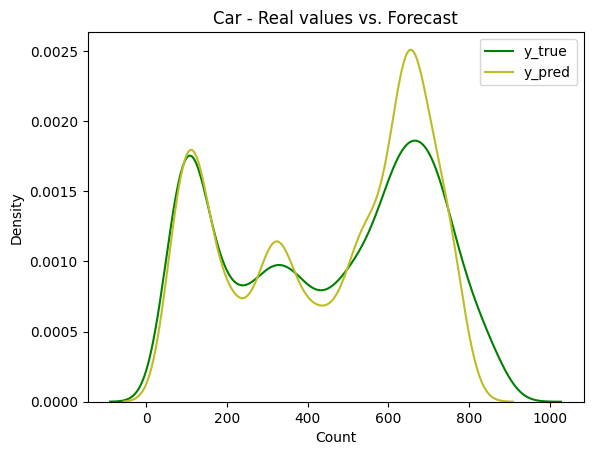

In [18]:
sns.kdeplot(y_test_pkw, color='green', label='y_true')
sns.kdeplot(y_pred_pkw, color=sns.color_palette()[8], label='y_pred')
# Titel und Achsenbeschriftungen
plt.title("Car - Real values vs. Forecast")
plt.xlabel("Count")
plt.ylabel("Density")
plt.legend()
plt.show()

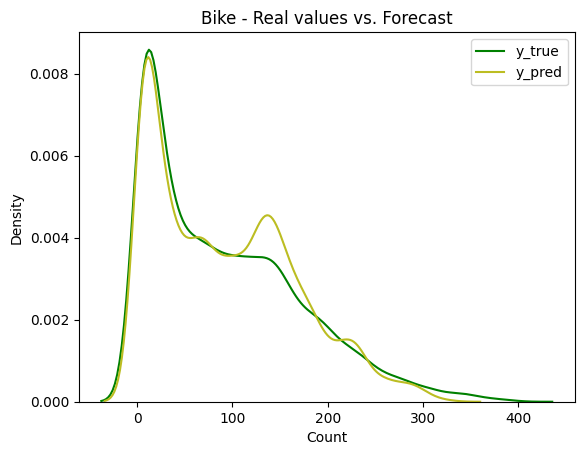

In [19]:
sns.kdeplot(y_test_fahrrad, color='green', label='y_true')
sns.kdeplot(y_pred_fahrrad, color=sns.color_palette()[8], label='y_pred')
# Titel und Achsenbeschriftungen
plt.title("Bike - Real values vs. Forecast")
plt.xlabel("Count")
plt.ylabel("Density")
plt.legend()
plt.show()

In [20]:
y_diff_pkw = y_test_pkw - y_pred_pkw
y_diff_fahrrad = y_test_fahrrad - y_pred_fahrrad

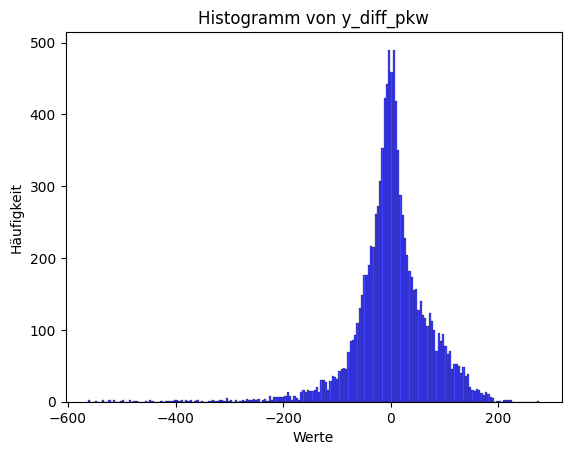

In [21]:
sns.histplot(y_diff_pkw, bins=200, kde=False, color='blue')
plt.title("Histogramm von y_diff_pkw")
plt.xlabel("Werte")
plt.ylabel("Häufigkeit")
plt.show()

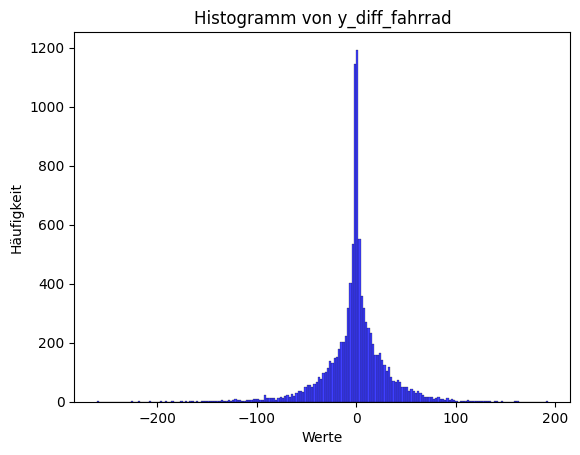

In [22]:
sns.histplot(y_diff_fahrrad, bins=200, kde=False, color='blue')
plt.title("Histogramm von y_diff_fahrrad")
plt.xlabel("Werte")
plt.ylabel("Häufigkeit")
plt.show()

In [23]:
type(y_test_fahrrad - y_pred_fahrrad)

pandas.core.series.Series

In [24]:
mse = mean_squared_error(y_test, y_pred)

In [25]:
print(y_diff_pkw.mean())
print(y_diff_pkw.std())
print("")
print(y_diff_fahrrad.mean())
print(y_diff_fahrrad.std())

1.5686360596604172
70.10280345603832

-0.5911699304424188
30.904565038922314


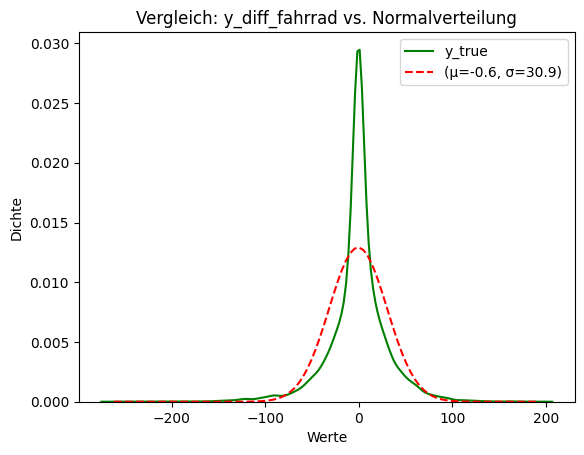

In [26]:
sns.kdeplot(y_diff_fahrrad, color='green', label='y_true')
#sns.kdeplot(y_pred_fahrrad, color=sns.color_palette()[8], label='y_pred')
# Titel und Achsenbeschriftungen
plt.title("Fahrrad - echte Werte vs. Voraussage")
plt.xlabel("Anzahl")
plt.ylabel("Dichte")

# Normalverteilung berechnen (mit vorgegebenem mean und std)
mean = y_diff_fahrrad.mean()  # Mittelwert
std = y_diff_fahrrad.std()   # Standardabweichung
x = np.linspace(y_diff_fahrrad.min() - 1, y_diff_fahrrad.max() + 1, 100)  # Wertebereich erweitern
normal_curve = norm.pdf(x, mean, std)

# Normalverteilung plotten
plt.plot(x, normal_curve, label=f"(µ={mean:.1f}, σ={std:.1f})", color="red", linestyle="--")

# Titel und Achsenbeschriftungen
plt.title("Vergleich: y_diff_fahrrad vs. Normalverteilung")
plt.xlabel("Werte")
plt.ylabel("Dichte")

# Legende hinzufügen
plt.legend()
plt.show()

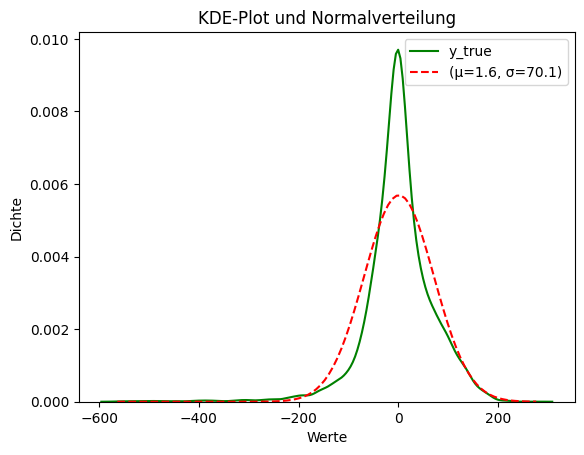

In [27]:
sns.kdeplot(y_diff_pkw, color='green', label='y_true')
#sns.kdeplot(y_pred_pkw, color=sns.color_palette()[8], label='y_pred')
# Titel und Achsenbeschriftungen
plt.title("pkw - echte Werte vs. Voraussage")
plt.xlabel("Anzahl")
plt.ylabel("Dichte")

# Normalverteilung berechnen (mit vorgegebenem mean und std)
mean = y_diff_pkw.mean()  # Mittelwert
std = y_diff_pkw.std()   # Standardabweichung
x = np.linspace(y_diff_pkw.min() - 1, y_diff_pkw.max() + 1, 100)  # Wertebereich erweitern
normal_curve = norm.pdf(x, mean, std)

# Normalverteilung plotten
plt.plot(x, normal_curve, label=f"(µ={mean:.1f}, σ={std:.1f})", color="red", linestyle="--")

# Titel und Achsenbeschriftungen
plt.title("KDE-Plot und Normalverteilung")
plt.xlabel("Werte")
plt.ylabel("Dichte")

# Legende hinzufügen
plt.legend()
plt.show()